# Classifying different spots in Tokyo

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

Create folders and download files from URLs in csv files of the appropriate images

In [5]:
from glob import glob

In [6]:
files = glob('data/lesson1_hw/*.csv')
folders = [file.replace('.csv','') for file in files]

In [7]:
path = Path('data/lesson1_hw/') 

In [6]:
def get_pics_from_csv(files):
    for file in files:
        dest = Path(file.replace('.csv',''))
        dest.mkdir(parents=True, exist_ok=True)
        download_images(Path(file), dest, max_pics=200)

In [ ]:
get_pics_from_csv(files)

In [8]:
classes = [folder.replace(str(path)+'/','') for folder in folders]
classes

['roppongi_hills',
 'tsukiji',
 'meiji_jingu',
 'shinjuku',
 'imperial_palace',
 'tokyo_tower',
 'sensoji',
 'shinjuku_gyoen',
 'shibuya_crossing',
 'skytree',
 'odaiba',
 'akihabara',
 'ueno',
 'tokyo_station']

## View data

In [35]:
np.random.seed(42)
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4)
data = ImageDataBunch.from_folder(path, train=".", ds_tfms=get_transforms(),valid_pct=0.1, size=224, num_workers=4)

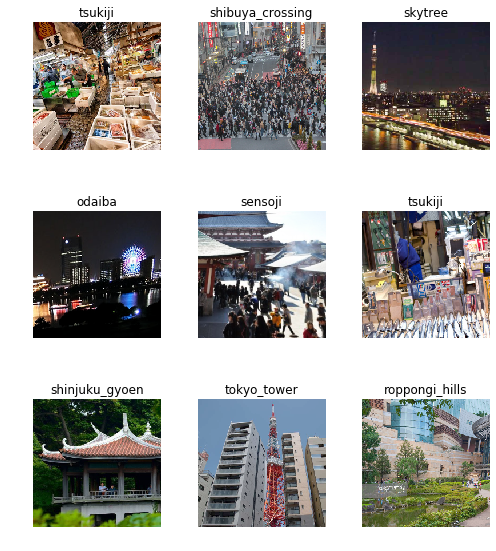

In [36]:
data.show_batch(rows=3, figsize=(7,8))

## Delete bad/mislabeled images

In [11]:
from fastai.widgets import *
paths  = np.concatenate([data.train_ds.ds.x,data.valid_ds.ds.x])

In [12]:
fd = FileDeleter(file_paths=paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

## Train model

In [37]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

Total time: 04:14
epoch  train_loss  valid_loss  error_rate
1      1.846277    0.907847    0.264151    (01:05)
2      1.189972    0.738117    0.218868    (01:04)
3      0.897373    0.710079    0.215094    (01:01)
4      0.730683    0.701723    0.218868    (01:02)



In [14]:
learn.unfreeze()

In [13]:
learn.lr_find(start_lr=1e-5,end_lr=1e-2,stop_div=False)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


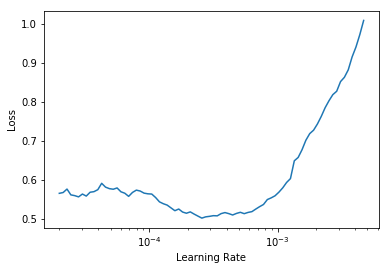

In [17]:
learn.recorder.plot(skip_end=10)

In [18]:
learn.save('stage-1')

In [28]:
learn.load('stage-1')

In [39]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,2e-4))

Total time: 04:08
epoch  train_loss  valid_loss  error_rate
1      0.433720    0.244400    0.064394    (01:05)
2      0.375720    0.245541    0.075758    (00:59)
3      0.363026    0.241089    0.083333    (01:03)
4      0.348774    0.239739    0.075758    (00:59)



In [40]:
learn.save('stage-2')

In [38]:
learn.load('stage-2')

## Interpretation

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

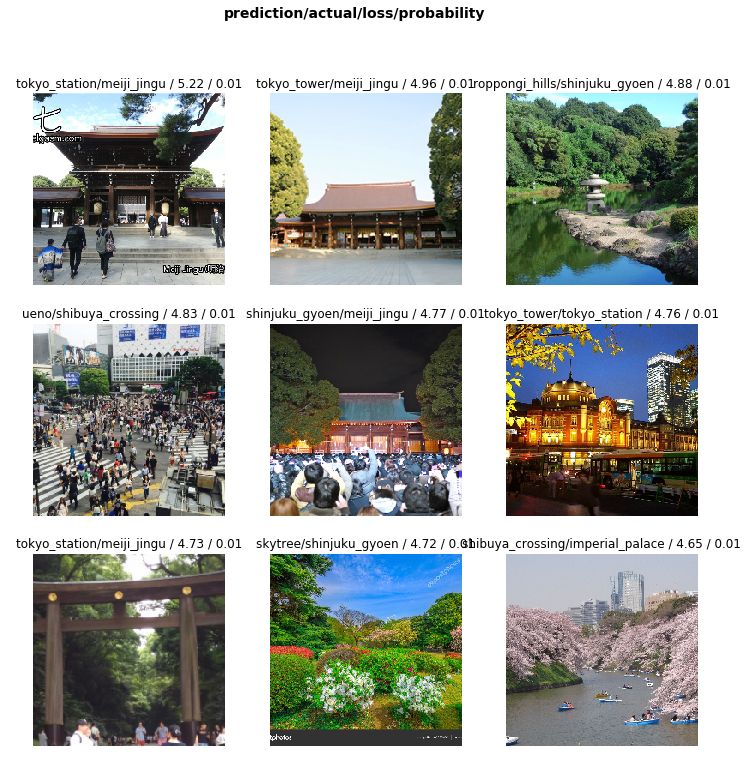

In [26]:
interp.plot_top_losses(9)

In [52]:
interp.p

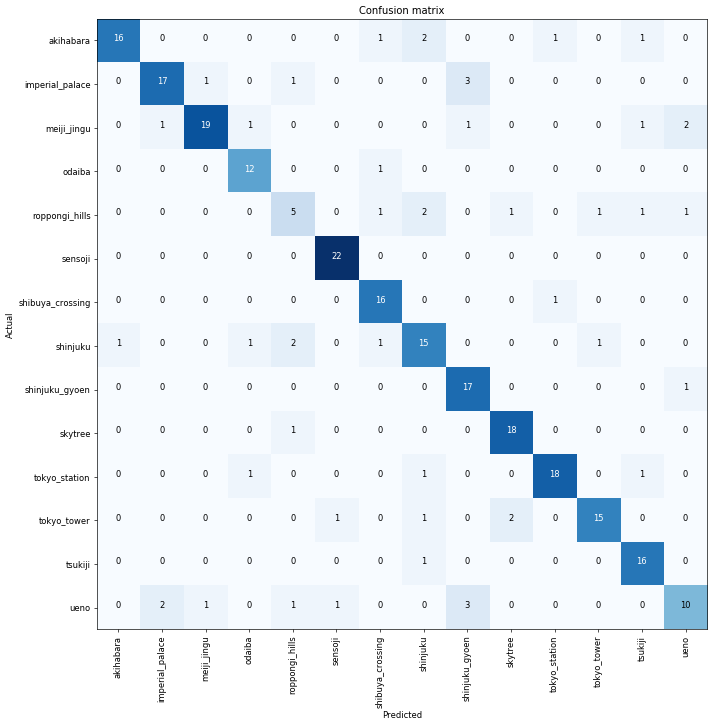

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('imperial_palace', 'shinjuku_gyoen', 3), ('ueno', 'shinjuku_gyoen', 3)]

In [19]:
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [34]:
print(top_loss_paths[30:35])

[PosixPath('data/lesson1_hw/roppongi_hills/00000049.jpg') PosixPath('data/lesson1_hw/meiji_jingu/00000071.jpg')
 PosixPath('data/lesson1_hw/meiji_jingu/00000176.jpg') PosixPath('data/lesson1_hw/shinjuku_gyoen/00000050.jpg')
 PosixPath('data/lesson1_hw/shibuya_crossing/00000165.jpg')]


In [20]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

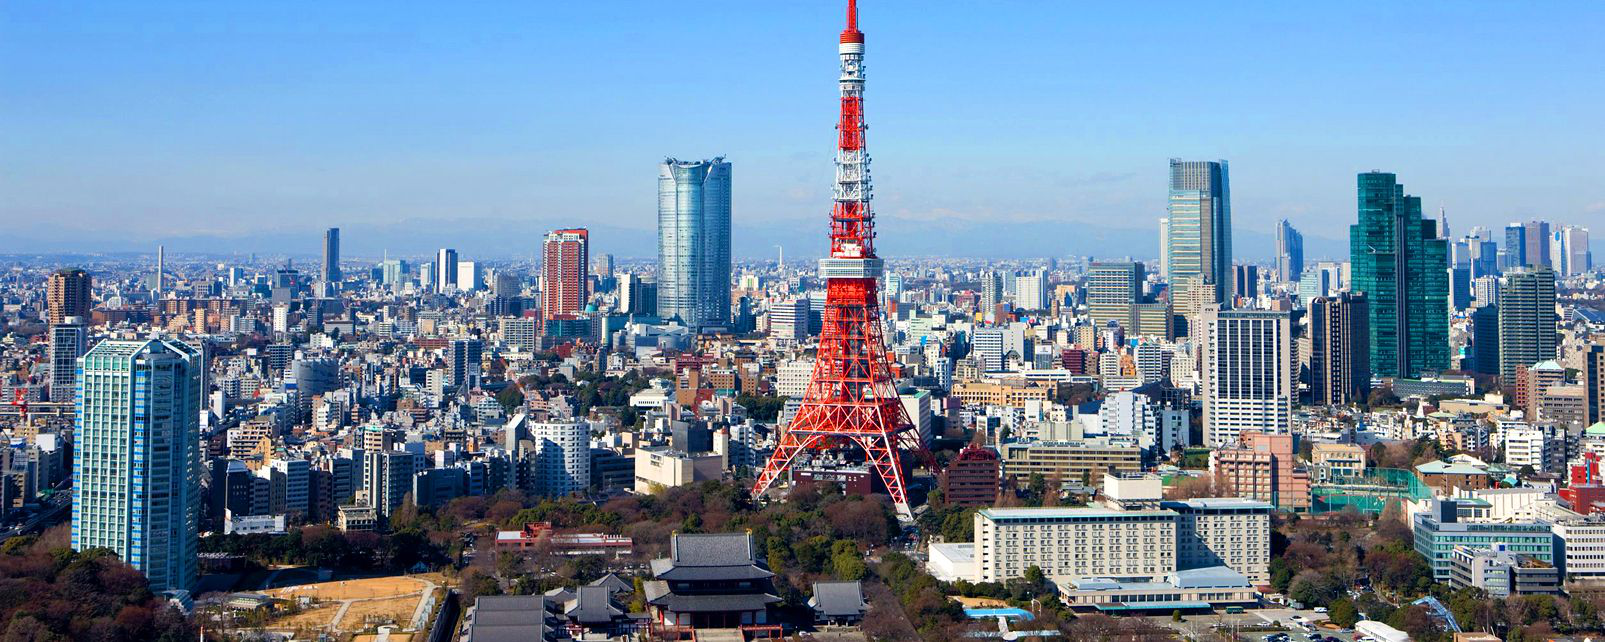

In [21]:
img = open_image(path/'tokyo_tower'/'00000050.jpg')
img

In [43]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'tokyo_tower'

## Test deployed App

In [23]:
import requests

In [50]:
url = 'https://cdn.japantimes.2xx.jp/wp-content/uploads/2018/08/p12-cade-tell-a-20180830-870x580.jpg'
a = requests.get('http://0.0.0.0:8888/classify-url?url={}'.format(url))

In [51]:
a.json()

{'predictions': [['tokyo_tower', 1374.6160888671875],
  ['roppongi_hills', 75.04361724853516],
  ['skytree', 8.656367301940918],
  ['shinjuku', 0.8515119552612305],
  ['shibuya_crossing', 0.8324117660522461],
  ['tokyo_station', 0.3411955237388611],
  ['akihabara', 0.3349566161632538],
  ['sensoji', 0.2842327654361725],
  ['odaiba', 0.21769091486930847],
  ['ueno', 0.20522984862327576],
  ['meiji_jingu', 0.195721834897995],
  ['tsukiji', 0.15193136036396027],
  ['shinjuku_gyoen', 0.12480831146240234],
  ['imperial_palace', 0.0832858756184578]],
 'pred_class': 'tokyo_tower'}